<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/PINN_LaPlace2D_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/dr-aheydari/SoftAdapt.git

  Cloning https://github.com/dr-aheydari/SoftAdapt.git to /tmp/pip-req-build-3s6immh0
  Running command git clone --filter=blob:none --quiet https://github.com/dr-aheydari/SoftAdapt.git /tmp/pip-req-build-3s6immh0
  Resolved https://github.com/dr-aheydari/SoftAdapt.git to commit 5fc955f424052cc94824d7ba9d7e7ea564c8e254
  Preparing metadata (setup.py) ... done
  Created wheel for softadapt: filename=softadapt-0.0.5-py3-none-any.whl size=15181 sha256=653bbe06b27541fd1023cbf4a07289fcf17bda2ab9e8831c8fe482c9b29d73c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-50dngp9h/wheels/d1/be/a6/ec235953fe96a72a3a6b4da3fe87a8fd3e2a73ce6f347b1c43
Successfully built softadapt


In [2]:
from softadapt import SoftAdapt, NormalizedSoftAdapt, LossWeightedSoftAdapt

#Network

In [4]:
import torch
import torch.nn as nn

class SineActivation(nn.Module):
    def forward(self, x):
        return torch.sin(x)

class FNN(nn.Module):
    def __init__(
        self,
        num_inputs: int = 2,
        num_layers: int = 4,
        num_neurons: int = 256,
        dropout_rate: float = 0.5,  # Add dropout rate as a parameter
        act: nn.Module = SineActivation(),
    ) -> None:
        """Basic neural network architecture with linear layers

        Args:
            num_inputs (int, optional): the dimensionality of the input tensor
            num_layers (int, optional): the number of hidden layers
            num_neurons (int, optional): the number of neurons for each hidden layer
            act (nn.Module, optional): the non-linear activation function to use for stitching
                linear layers togeter
        """
        super().__init__()

        self.num_inputs = num_inputs
        self.num_neurons = num_neurons
        self.num_layers = num_layers

        layers = []

        # input layer
        layers.append(nn.Linear(self.num_inputs, num_neurons))

        # hidden layers with linear layer and activation
        for i in range(num_layers):
            layers.extend([nn.Linear(num_neurons, num_neurons),act])
            # Add dropout after every other linear layer
            #if i % 2 == 1:
            #  layers.extend([nn.Linear(num_neurons, num_neurons),act])
            #else:
            #  layers.extend([nn.Linear(num_neurons, num_neurons), nn.Dropout(dropout_rate) ,act])


        # output layer
        layers.append(nn.Linear(num_neurons, 1))

        # build the network
        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x).squeeze()

#network

# Example usage:
"""
model = LinearNN()
input_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features
output = model(input_tensor)

print("Input shape:", input_tensor)
print("Output shape:", output)"""

'\nmodel = LinearNN()\ninput_tensor = torch.randn((10, 2))  # Example input with batch size 10 and 2 features\noutput = model(input_tensor)\n\nprint("Input shape:", input_tensor)\nprint("Output shape:", output)'

#PINN Loss

In [3]:
import torch.nn.functional as F
import torch.autograd.functional as autograd

def data_loss(predicted_data, target_data): #data has to be in z=0, 0<x<L
        #target data is obtained using behaviour function
        #return F.mse_loss(predicted_data, target_data)
        criterion=torch.nn.L1Loss()
        #criterion=torch.nn.MSELoss()
        #target_data = target_data.view(-1, 1)  # Assuming you want a column vector
        predicted_data =predicted_data.view(-1,1)
        #print("TARGET: ",target_data.shape)
        #print("PREDICTED :",predicted_data.shape)
        return criterion(predicted_data, target_data)

def boundary_condition_loss(boundary_conditions,output):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output)) + criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def periodic_boundary_loss(boundary_conditions):
    # Customize based on your specific boundary conditions
    # Example: Dirichlet boundary condition u(0, t) = g(t)
    #loss_bc = F.mse_loss(boundary_conditions['bc1'], torch.zeros_like(output)) + F.mse_loss(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    # instead of 0 it will be an array of zeros with the same length as the number of points we decide to use to calculate the loss
    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc2_0'], boundary_conditions['bc2_1'])
    return loss_bc

def bottom_velocity_boundary_loss(boundary_conditions,output):

    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc1'], torch.zeros_like(output))
    return loss_bc

def object_velocity_boundary_loss(boundary_conditions,output):

    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    loss_bc = criterion(boundary_conditions['bc3'], torch.zeros_like(output))
    return loss_bc

def pde_loss(model,input_data): #here input_data has to be in -h(x)<x2<0
#
#    # Forward pass to get the function values
#    output = model(input_data)
#    pde_residuals=[]
#    for o,d in zip(output,input_data):
      # Compute the Hessian matrix
#      hessian = compute_hessian(o, d)

      # Extract elements corresponding to (0, 0) and (1, 1)
      #hessian_00 = hessian[0, 0]
      #hessian_11 = hessian[1, 1]

      #pde_residuals.append(hessian_00+hessian_11)
    pde_residuals_tensor = compute_hessian(model,input_data)
    #print(f"{hessians.sum(dim=1)}")
    #pde_residuals_tensor = hessians.sum(dim=1)
    #pde_residuals_tensor = torch.cat([residual.unsqueeze(0) for residual in pde_residuals])

    # Use torch.zeros_like with the tensor
    #return F.mse_loss(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))
    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    return criterion(pde_residuals_tensor, torch.zeros_like(pde_residuals_tensor))

def  body_boundary_loss(boundary_conditions,output):
    criterion=torch.nn.L1Loss()
    #criterion=torch.nn.MSELoss()
    loss_b = criterion(boundary_conditions['bc_body_b'], torch.zeros_like(output))
    loss_t = criterion(boundary_conditions['bc_body_t'], torch.zeros_like(output))
    loss_r = criterion(boundary_conditions['bc_body_r'], torch.zeros_like(output))
    loss_l = criterion(boundary_conditions['bc_body_l'], torch.zeros_like(output))

    loss_body=loss_b+loss_t+loss_r+loss_l
    return loss_body

def compute_bc1(model,  x1,x2):

    x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
    x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

    # Concatenate x1 and x2 to form the input tensor
    input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

    # Forward pass through the model
    output = model(input_tensor)

    # Compute the gradient with respect to x2
    grad_x2 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]

    # Initialize a list to store the gradients for each element of x2_tensor
    #gradients_x2 = []

    # Compute the gradient for each element of output with respect to x2_tensor
    #for i in range(len(output)):
    #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
    #    gradients_x2.append(grad_x2_element)

    # Stack the gradients into a tensor
    #grad_x2 = torch.stack(gradients_x2, dim=0)

    #print(f'Gradient bottom: {grad_x2}')
    return grad_x2

def compute_bc2(model, input_tensor):

    # Forward pass through the model
    output = model(input_tensor)

    #print(f'output: {output}')
    return output

def compute_bc3(model,  x1,x2):

  x1_tensor = torch.tensor(x1, dtype=torch.float32, requires_grad=True)
  x2_tensor = torch.tensor(x2, dtype=torch.float32 , requires_grad=True)

  # Concatenate x1 and x2 to form the input tensor
  input_tensor = torch.stack([x1_tensor, x2_tensor], dim=1)

  # Forward pass through the model
  output = model(input_tensor)

  # Compute the gradient with respect to x2
  grad_x1 = torch.autograd.grad(output, input_tensor,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 0]

  # Initialize a list to store the gradients for each element of x2_tensor
  #gradients_x2 = []

  # Compute the gradient for each element of output with respect to x2_tensor
  #for i in range(len(output)):
  #    grad_x2_element = torch.autograd.grad(output[i], x2_tensor[i], create_graph=True)[0]
  #    gradients_x2.append(grad_x2_element)

  # Stack the gradients into a tensor
  #grad_x2 = torch.stack(gradients_x2, dim=0)

  #print(f'Gradient bottom: {grad_x2}')
  return grad_x1

#def compute_hessian(output, input_data):
#    hessian = autograd.hessian(lambda x: output, input_data)
#    return hessian

def compute_hessian(model, input_data):
    output = model(input_data)
    # Calculate the first-order gradients
    gradients = torch.autograd.grad(output, input_data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # Calculate the second-order gradients for each element of input_data
    hessian = torch.zeros_like(input_data)
    for i in range(input_data.shape[1]):
      hessian[:, i] = torch.autograd.grad(gradients[:, i], input_data, grad_outputs=torch.ones_like(gradients[:, i]), create_graph=True)[0][:, i]

    return hessian.sum(dim=1)
#x1 and x2 have to represent the points we want to apply the constraints

#boundary_conditions = {
#    'bc1': compute_bc1(model, x1, -1),   # at x2=-1 the grad perpendicular to the bottom is null
#    'bc2_0': compute_bc2(model, 0, x2),  # at x1 = 0
#    'bc2_1': compute_bc2(model, 2, x2),  # at x1 = 2
#}

#total_loss = loss_data + loss_bc + loss_pde

#the data we provide to calculate each loss is extremely important. It has to belong to the domain where the constraints/pde/function are applied.

#Functions analytical calculation




In [9]:
import numpy as np
import math

# General parameters
L = 2.0 # wave/x length
h = 1 # depth
T = 1 # period
H = 0.05 # surface wave amplitude (I chose it arbitrarliy. Check p. 68 HRC)
c = L/T # wave propagation velocity (p. 70 HCR)
k = 2*np.pi/L # wave nr.
w = 2*np.pi/T

t = 0 # we are looking at a snapshot, so t is constant

# Analytical solution (HRC p. 75)
def behaviour_func(x):
    return -H*c/2 * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

def velocity_func(x):

  u= H*c/2 * k * np.cosh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.cos(w*t-k*x[:, 0:1])
  v= -H*c/2 * k * np.sinh(k*(x[:, 1:2]+h))/np.sinh(k*h) * np.sin(w*t - k*x[:, 0:1])

  return u,v

#Generate data

In [10]:
def  generate_data_function_approximation(size): #data generator for data loss and can also be used to train the network
  # Generate random values for x and t
    x1 = np.random.uniform(0, L, size)
    x2 = np.zeros_like(x1)
    #t = np.random.uniform(0, 1, size)

    # Create input data by stacking x1, x2, and t
    #input_data = np.column_stack((x1, x2, t))
    input_data = np.column_stack((x1, x2))

    # Compute the corresponding function values using the analytical solution
    target_data = behaviour_func(input_data)

    return input_data, target_data

def generate_data_pde_loss(size):
    # Generate random values for x1 and x2 within the specified PDE domain
    x1 = np.random.uniform(0, L, size)
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_data_pde_loss_with_body(size):
    new_size = size/4
    new_size= int(new_size)
    # Generate random values for x1 and x2 within the specified PDE domain
    x1_l = np.random.uniform(0, L/2-L/16, new_size)
    x2_l = np.random.uniform(-h, 0, new_size)

    x1_r = np.random.uniform(L/2+L/16, L, new_size)
    x2_r = np.random.uniform(-h, 0, new_size)

    x1_t = np.random.uniform(L/2-L/16, L/2+L/16, new_size)
    x2_t = np.random.uniform(-h/2+L/16,0, new_size)

    x1_b = np.random.uniform(L/2-L/16, L/2+L/16, new_size)
    x2_b = np.random.uniform(-h, -h/2-L/16 , new_size)

    # Appending all the zones:
    x1 = np.concatenate([x1_l, x1_r, x1_t, x1_b])
    x2 = np.concatenate([x2_l, x2_r, x2_t, x2_b])
    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_periodic_boundary_data(size, x1_values):

    x1_0=np.full(size,x1_values[0]);
    x1_1=np.full(size,x1_values[1]);

    # Generate random values for x2 within the specified range for each x1
    x2 = np.random.uniform(-h, 0, size)

    # Create input data by stacking x1 and x2
    input_data_0=input_data = np.column_stack((x1_0, x2))
    input_data_1 = np.column_stack((x1_1, x2))

    return input_data_0,input_data_1
def generate_data_bottom_velocity(size):

    x2=np.full(size,-h);
    x1 = np.random.uniform(0, L, size)

    # Create input data by stacking x1 and x2
    input_data = np.column_stack((x1, x2))

    return input_data

def generate_data_body(size):

    #create bottom square data
    x2_b=np.full(size,-h/2-L/16);
    x1_b= np.random.uniform(L/2-L/16, L/2+L/16, size)

    # Create input data by stacking x1 and x2
    input_data_b = np.column_stack((x1_b, x2_b))

    #create top square data
    x2_t=np.full(size,-h/2+L/16);
    x1_t= np.random.uniform(L/2-L/16, L/2+L/16, size)

    # Create input data by stacking x1 and x2
    input_data_t = np.column_stack((x1_t, x2_t))

    #create right square data
    x1_r=np.full(size,L/2+L/16);
    x2_r= np.random.uniform(-h/2-L/16, -h/2+L/16, size)

    # Create input data by stacking x1 and x2
    input_data_r = np.column_stack((x1_r, x2_r))

    #create left square data
    x1_l=np.full(size,L/2-L/16);
    x2_l= np.random.uniform(-h/2-L/16, -h/2+L/16, size)

    # Create input data by stacking x1 and x2
    input_data_l = np.column_stack((x1_l, x2_l))


    return input_data_b,input_data_t,input_data_r,input_data_l

#size = 10  # specify the desired size
#input_data, target_data = generate_data_z0(size)
#generate_pde_input_data(size)

#x1_values = np.array([0, 2])  # specify the x1 values
#input_data_0,input_data_1 = generate_periodic_boundary_data(size, x1_values)
#print(input_data_0,input_data_1)
#print(generate_bottom_velocity_data(10))

_,_,_,data=generate_data_body(5)

print(data)

[[ 0.875      -0.61564588]
 [ 0.875      -0.53446395]
 [ 0.875      -0.38950409]
 [ 0.875      -0.439092  ]
 [ 0.875      -0.59658534]]


In [ ]:
data1 = generate_data_pde_loss_with_body(20)
print(data1)
data2 = generate_data_pde_loss(20)
print(data2)
type(data2)

[[ 0.16779427 -0.03284135]
 [ 0.8473455  -0.39614008]
 [ 0.5007144  -0.58674189]
 [ 0.7321575  -0.92629305]
 [ 0.22869623 -0.70998236]
 [ 1.71898006 -0.65723652]
 [ 1.61192589 -0.59303341]
 [ 1.33903179 -0.37633458]
 [ 1.88834928 -0.89511438]
 [ 1.47452731 -0.60400961]
 [ 0.98784343 -0.21415227]
 [ 0.96993423 -0.099338  ]
 [ 0.95163651 -0.03381205]
 [ 0.98242185 -0.25011389]
 [ 1.00864276 -0.37059844]
 [ 1.10084934 -0.726068  ]
 [ 1.1072243  -0.78328553]
 [ 1.07551797 -0.77758122]
 [ 0.97711162 -0.64346602]
 [ 0.986366   -0.9861996 ]]
[[ 0.48807344 -0.319795  ]
 [ 1.70260304 -0.78483924]
 [ 0.14724572 -0.49128057]
 [ 0.58396937 -0.10410061]
 [ 1.23888723 -0.11974077]
 [ 1.00303212 -0.73920629]
 [ 1.55657769 -0.75395217]
 [ 1.33626501 -0.70618487]
 [ 1.80083012 -0.96059812]
 [ 1.95290117 -0.76767655]
 [ 1.34499152 -0.14389127]
 [ 0.8500016  -0.22616868]
 [ 0.30901188 -0.97337599]
 [ 0.70553877 -0.43755907]
 [ 1.686935   -0.5140972 ]
 [ 0.45915314 -0.83267208]
 [ 0.99185731 -0.61729208]


numpy.ndarray

In [ ]:
import torch
import torch.nn as nn
import torch.autograd.functional as autograd

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.relu = nn.Tanh()
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x  # Ensure the output is a scalar

#def compute_hessian2(model, input_data):

#    output=model(input_data)
#    grad_x2 = torch.autograd.grad(output, input_data,grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 1]
#    hessian = torch.autograd.grad(grad_x2, input_data,grad_outputs=torch.ones_like(grad_x2), create_graph=True)[0][:, 1]
#    return hessian

def compute_hessian2(model, input_data):
    output = model(input_data)
    # Calculate the first-order gradients
    gradients = torch.autograd.grad(output, input_data, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    # Calculate the second-order gradients for each element of input_data
    hessian = torch.zeros_like(input_data)
    for i in range(input_data.shape[1]):
      hessian[:, i] = torch.autograd.grad(gradients[:, i], input_data, grad_outputs=torch.ones_like(gradients[:, i]), create_graph=True)[0][:, i]

    return hessian.sum(dim=1)

# Rest of your code remains the same

# Create an instance of the neural network
model = SimpleNN()

# Generate some random input data
input_data = torch.randn((10, 2), requires_grad=True)

# Forward pass to get the function values
#output = model(input_data)

hessian = compute_hessian2(model, input_data)
print(f'Hessian : {hessian}')
# Compute the Hessian matrix





Hessian : tensor([-0.0179, -0.0597, -0.0649,  0.1232,  0.1324, -0.0248,  0.1801,  0.0924,
        -0.0376,  0.1443], grad_fn=<SumBackward1>)


In [5]:
import torch
import torch.nn as nn

# Define a simple neural network
class Simple2DNN(nn.Module):
    def __init__(self):
        super(Simple2DNN, self).__init__()
        self.fc1 = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc1(x)

# Instantiate the model
model = Simple2DNN()

# Create a 2D input tensor
x_input_2d = torch.tensor([[2.0, 3.0]], dtype=torch.float32, requires_grad=True)

# Forward pass through the model
output = model(x_input_2d)

# Compute the gradient with respect to the first dimension (index 0)
grad_input_1 = torch.autograd.grad(output, x_input_2d, grad_outputs=torch.ones_like(output), create_graph=True)[0][:, 0]

# Print the results
print("Input Tensor (2D):")
print(x_input_2d)
print("\nOutput Tensor:")
print(output)
print("\nGradient with respect to the First Dimension:")
print(grad_input_1)



Input Tensor (2D):
tensor([[2., 3.]], requires_grad=True)

Output Tensor:
tensor([[-2.6197]], grad_fn=<AddmmBackward0>)

Gradient with respect to the First Dimension:
tensor([-0.3682], grad_fn=<SelectBackward0>)


#Normalize data

In [11]:
def normalize_data(data_function_approximation,data_boundary_conditions_0,data_boundary_conditions_1,data_pde_loss,data_vel_bottom,data_size):
  total_input_train_data=[]

  total_input_train_data.extend(data_function_approximation)
  total_input_train_data.extend(data_boundary_conditions_0)
  total_input_train_data.extend(data_boundary_conditions_1)
  total_input_train_data.extend(data_pde_loss)
  total_input_train_data.extend(data_vel_bottom)


  scaler = StandardScaler()
  total_input_train_data_scaled= scaler.fit_transform(total_input_train_data)
  #input_data_function_approximation = scaler.fit_transform(input_data_function_approximation)
  #input_data_boundary_conditions_0 = scaler.fit_transform(input_data_boundary_conditions_0)
  #input_data_boundary_conditions_1 = scaler.fit_transform(input_data_boundary_conditions_1)
  #input_data_vel_bottom = scaler.fit_transform(input_data_vel_bottom)
  #input_data_pde_loss = scaler.fit_transform(input_data_pde_loss)

  #print(total_input_train_data_scaled[:,0])
  #print(total_input_train_data_scaled[:,1])


  input_data_function_approximation = total_input_train_data_scaled[0:data_size,:]
  input_data_boundary_conditions_0 = total_input_train_data_scaled[data_size:2*data_size,:]
  input_data_boundary_conditions_1 = total_input_train_data_scaled[2*data_size:3*data_size,:]
  input_data_pde_loss = total_input_train_data_scaled[3*data_size:4*data_size,:]
  input_data_vel_bottom = total_input_train_data_scaled[4*data_size:5*data_size,:]

  return input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom

#Training Network

### Parameters and data

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define parameters
num_epochs = 5000
learning_rate = 10**-4
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=20
test_data_size=8 #it has to be multiple of 4

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss(training_data_size)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)



#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom = normalize_data(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom,training_data_size)

# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1])

### Training Loop

In [13]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)

    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                                 torch.tensor(values_of_component_2),
                                                                 torch.tensor(values_of_component_3),
                                                                torch.tensor(values_of_component_4),
                                                                 verbose=False,
                                                                   )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + adapt_weights[1]*loss_periodic_boundary + adapt_weights[2]*loss_pde_loss + adapt_weights[3]*loss_vel_bottom_boundary
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()



    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)


    test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary + test_loss_pde_loss

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Epoch 0/5000,train PDE Loss: 0.011655891314148903
Epoch 0/5000,train Periodic Boundary Loss: 0.04863538593053818
Epoch 0/5000,train Bottom Velocity Boundary Loss: 0.06480707228183746
Epoch 0/5000,train Data Loss: 0.09244880825281143
Epoch 0/5000,train Total Loss: 0.21754716336727142
------------------------------------------------------------
Epoch 0/5000,test PDE Loss: 0.009224945679306984
Epoch 0/5000,test Periodic Boundary Loss: 0.0372471921145916
Epoch 0/5000,test Bottom Velocity Boundary Loss: 0.03695347160100937
Epoch 0/5000,test Data Loss: 0.07147929072380066
Epoch 0/5000,test Total Loss: 0.15490490198135376
#############################################################
#############################################################
Epoch 100/5000,train PDE Loss: 0.0008911727927625179
Epoch 100/5000,train Periodic Boundary Loss: 0.006591989193111658
Epoch 100/5000,train Bottom Velocity Boundary Loss: 0.0011881357058882713
Epoch 100/5000,train Data Loss: 0.021398304030299187
Epoch 1

#Losses plots

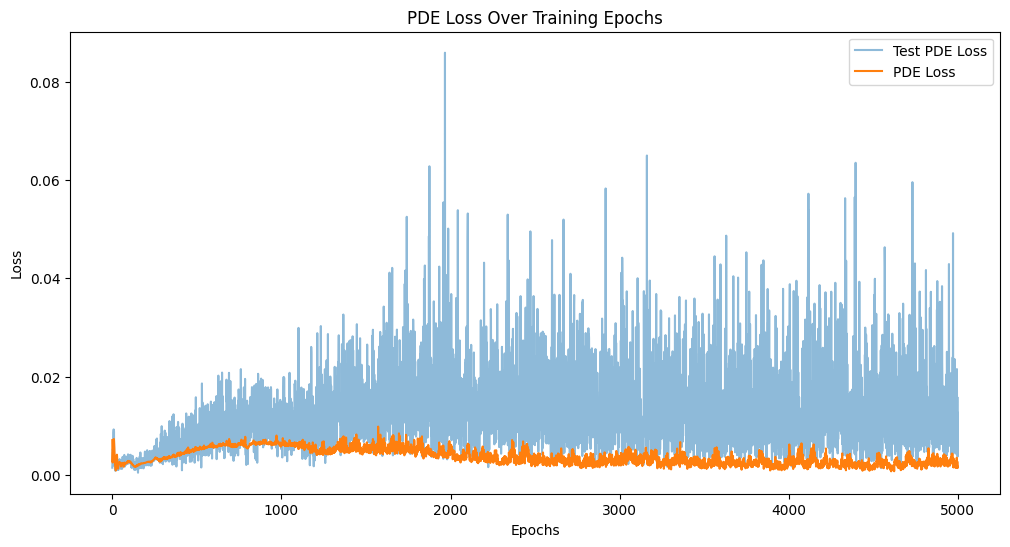

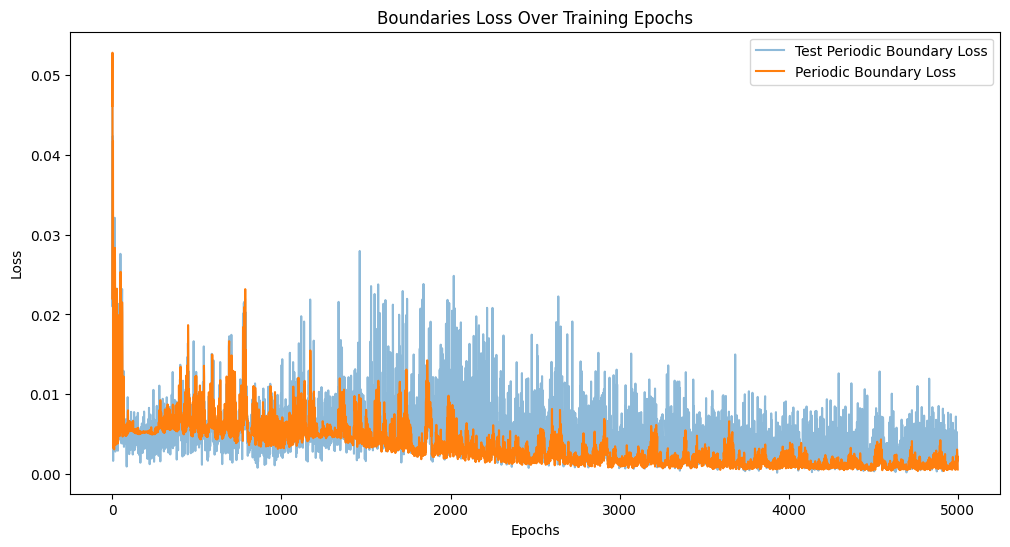

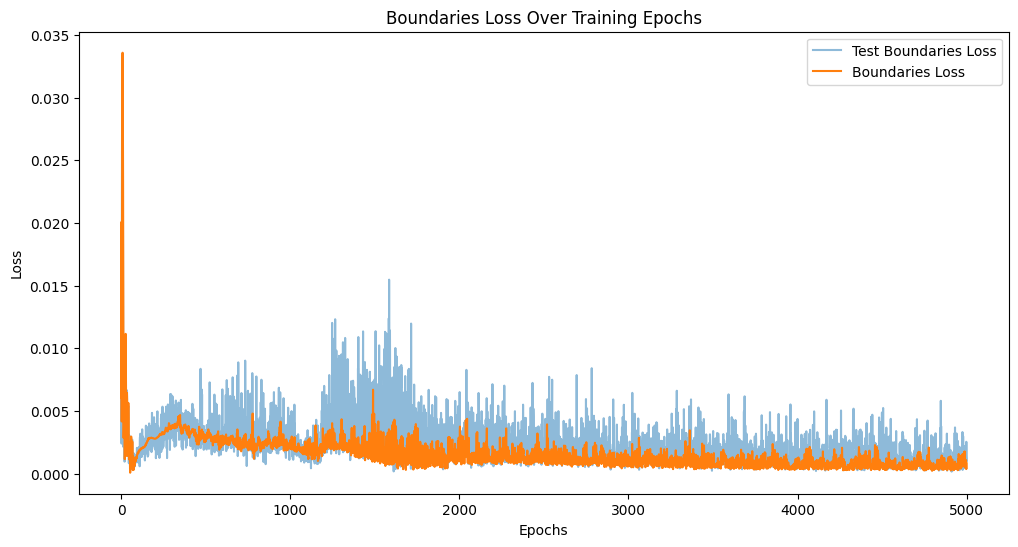

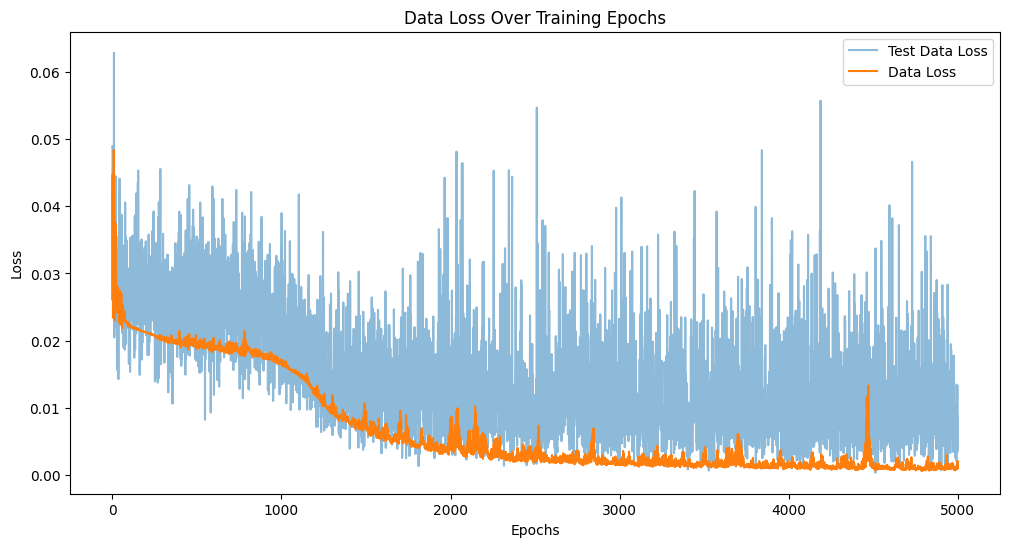

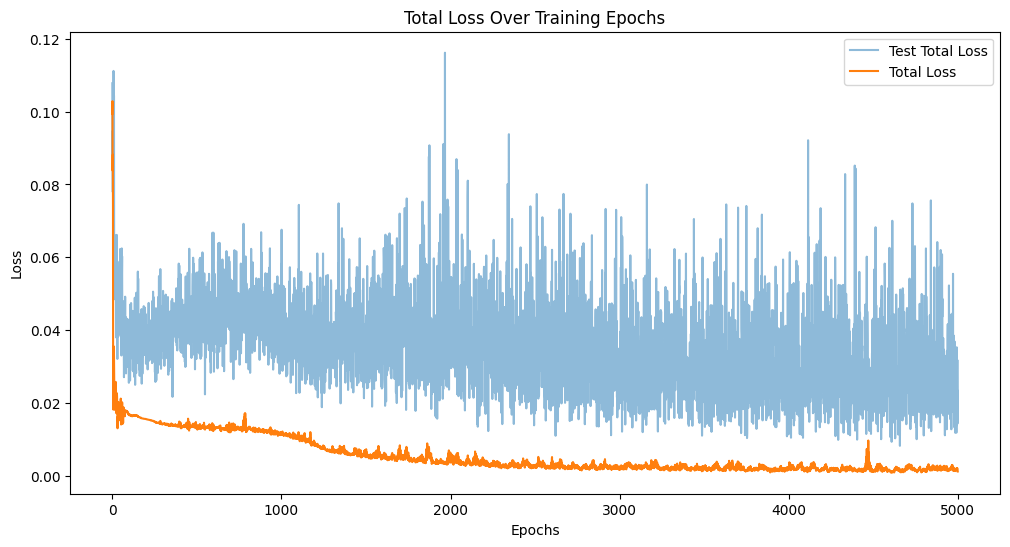

In [ ]:
epochs_range = range(0, num_epochs, 1)
# Plotting PDE Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_pde_list, label='Test PDE Loss', alpha=.5)
plt.plot(epochs_range, loss_pde_list, label='PDE Loss')
plt.title('PDE Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Periodic Boundary Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_per_bc_list, label='Test Periodic Boundary Loss', alpha=.5)
plt.plot(epochs_range, loss_per_bc_list, label='Periodic Boundary Loss')
plt.title('Boundaries Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Boundaries Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_bot_vel_bc_list, label='Test Boundaries Loss', alpha=.5)
plt.plot(epochs_range, loss_bot_vel_bc_list, label='Boundaries Loss')
plt.title('Boundaries Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Data Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_loss_data_list, label='Test Data Loss', alpha=.5)
plt.plot(epochs_range, loss_data_list, label='Data Loss')
plt.title('Data Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting Total Loss
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, test_total_loss_list, label='Test Total Loss', alpha=.5)
plt.plot(epochs_range, total_loss_list, label='Total Loss')
plt.title('Total Loss Over Training Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#3D Plot with test data

In [16]:
total_test_data = []
total_test_data_scaled = []
test_data_size=50
#generate test data
test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
test_input_data_pde_loss = generate_data_pde_loss(test_data_size)
test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)

#WARNING: the values added here must be the same as in standardized data
total_test_data.extend(test_input_data_function_approximation)
total_test_data.extend(test_input_data_boundary_conditions_0)
total_test_data.extend(test_input_data_boundary_conditions_1)
total_test_data.extend(test_input_data_pde_loss)
total_test_data.extend(test_input_data_vel_bottom)

#normalize data
test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom = normalize_data(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom,test_data_size)


#add standardized data
#WARINING: the values added here must be the same as above
total_test_data_scaled.extend(test_input_data_function_approximation)
total_test_data_scaled.extend(test_input_data_boundary_conditions_0)
total_test_data_scaled.extend(test_input_data_boundary_conditions_1)
total_test_data_scaled.extend(test_input_data_pde_loss)
total_test_data_scaled.extend(test_input_data_vel_bottom)

total_test_data = torch.Tensor(total_test_data)
total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor
output2= model(total_test_data_scaled)

print(output2.shape,(total_test_data_scaled.shape))
print(total_test_data.shape)

torch.Size([250]) torch.Size([250, 2])
torch.Size([250, 2])


In [15]:
x = total_test_data[:,0]
y = total_test_data[:,1]
print(x,y)

tensor([0.9651, 1.4648, 0.9365, 1.7512, 1.3963, 0.3935, 0.1280, 0.1363, 0.8533,
        0.7721, 0.3999, 1.3657, 1.6533, 0.1983, 0.1205, 1.5775, 0.1891, 1.8695,
        1.3642, 1.4372, 0.1492, 0.0518, 0.0578, 1.9380, 0.3730, 1.5754, 1.3622,
        0.0603, 0.8833, 0.6654, 1.9678, 0.3181, 1.8049, 0.5057, 1.1678, 0.4780,
        0.1075, 1.1629, 1.8197, 1.1762, 0.6921, 1.1659, 0.6754, 0.2599, 1.8220,
        1.7835, 0.3142, 0.0252, 0.6668, 0.2776, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000, 2.0000,
        2.0000, 2.0000, 2.0000, 2.0000, 

# 3d Plot Model Output

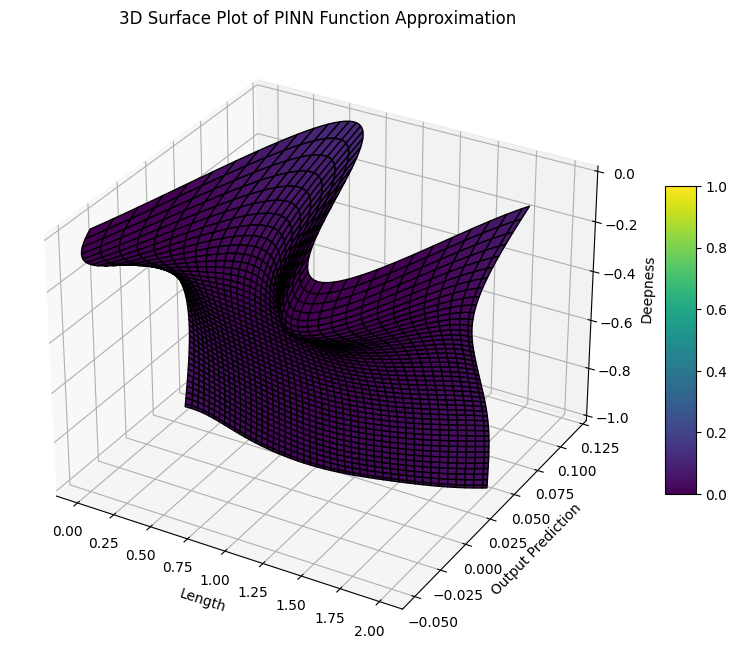

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your PINN output is stored in 'predicted_data_function_approximation'
# and input coordinates are stored in 'input_data_function_approximation'

x = np.linspace(0,2,90)
y = np.linspace(0,-1,90)
X,Y  = np.meshgrid(x,y)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

surface_output= model(torch.Tensor(scaled_data))
# Assuming the model output is 1D, reshape it to 2D
Z = surface_output.detach().numpy().reshape(X.shape)
#predicted_data_2d = Z.reshape(X.shape)




# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Z, Y, cmap='viridis', edgecolor='k', facecolors=plt.cm.viridis(Z))

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output Prediction')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Surface Plot of PINN Function Approximation')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)


# Show the plot
plt.show()

#3D Plot Analytical

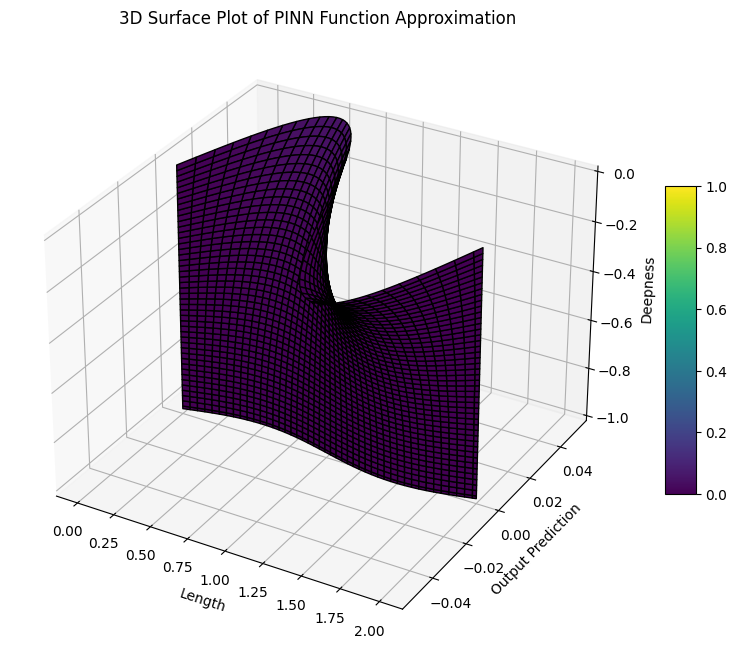

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming your PINN output is stored in 'predicted_data_function_approximation'
# and input coordinates are stored in 'input_data_function_approximation'

x = np.linspace(0,2,90)
y = np.linspace(0,-1,90)
X,Y  = np.meshgrid(x,y)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

surface_output= behaviour_func(data)
# Assuming the model output is 1D, reshape it to 2D
Z = surface_output.reshape(X.shape)
#predicted_data_2d = Z.reshape(X.shape)




# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(X, Z, Y, cmap='viridis', edgecolor='k', facecolors=plt.cm.viridis(Z))

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output Prediction')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Surface Plot of PINN Function Approximation')

# Add a color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)


# Show the plot
plt.show()

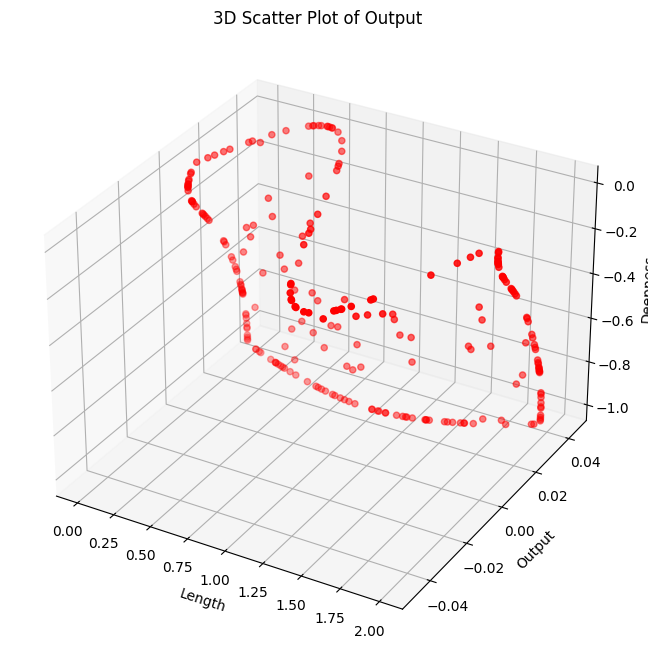

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = total_test_data[:,0]
y = total_test_data[:,1]
z = output2.detach().numpy()  # Convert the torch Tensor to a NumPy array


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,z, y, c='r', marker='o')

# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

#ax.view_init(elev=90, azim=90)  # better angle to analyze z=0
#ax.view_init(elev=0, azim=0)   #better angle to analyze periodic boundaries
# Show the plot
plt.show()


#Analytical Φ(z=0) vs Predicted Φ(z=0)

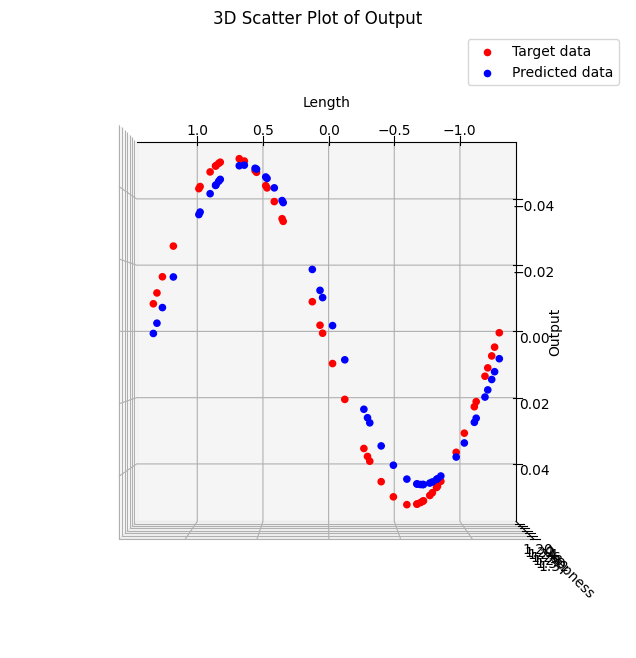

In [31]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming total_test_data[0] and total_test_data[1] are 1D arrays
x = test_input_data_function_approximation[:,0]
y = test_input_data_function_approximation[:,1]
zt = test_target_data_function_approximation  # Convert the torch Tensor to a NumPy array
zp = model(torch.Tensor(test_input_data_function_approximation))
zp= zp.detach().numpy()

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(x,zt, y, c='r', marker='o', label='Target data')
ax.scatter(x,zp, y, c='b', marker='o', label='Predicted data')

ax.legend()
# Set labels
ax.set_xlabel('Length')
ax.set_ylabel('Output')
ax.set_zlabel('Deepness')

# Set title
ax.set_title('3D Scatter Plot of Output')

ax.view_init(elev=90, azim=90)  # You can adjust the elev and azim values

# Show the plot
plt.show()

In [ ]:
def compute_output_grad(input):

    # Forward pass through the model
    output = model(input.requires_grad_())

    # Compute gradients with respect to both x1_tensor and x2_tensor using a single call
    grads = torch.autograd.grad(output, input, grad_outputs=torch.ones_like(output), create_graph=True)[0]

    grad_x1 = grads[:, 0]
    grad_x2 = grads[:, 1]

    return grad_x1, grad_x2

(2, 100)


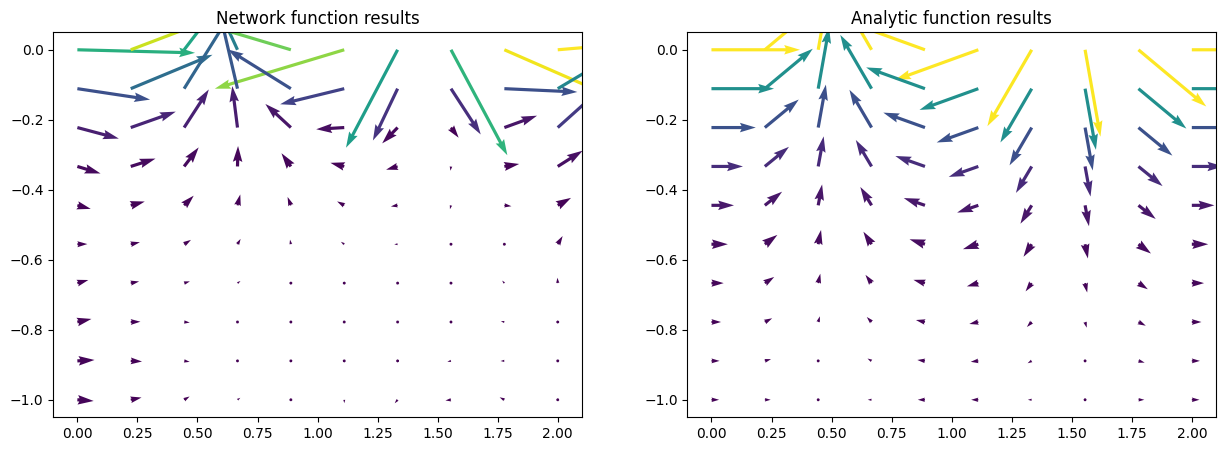

In [ ]:
square_top_left = (L/2 - L/16, -h/2 - L/16)
square_width = L/8  # You can adjust the width of the square as needed
square_height = L/8  # You can adjust the height of the square as needed

#body=True
body=False
x = np.linspace(0,2,30)
y = np.linspace(0,-1,30)
X,Y  = np.meshgrid(x,y)

positions = np.vstack([X.ravel(), Y.ravel()])
print(positions.shape)

# Stack X and Y vertically
data = np.vstack([X.flatten(), Y.flatten()]).T

# Create and fit the scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Calculate velocity of water for specific x,y direction
u_analytic, v_analytic  = velocity_func(positions.T)
u_network, v_network = compute_output_grad(torch.Tensor(scaled_data))
u_network = u_network.detach().numpy()
v_network = v_network.detach().numpy()


fig , axs = plt.subplots(1,2, figsize = (15,5))
axs[0].quiver(X,Y,u_network, v_network, v_network**2+u_network**2 )
axs[0].set_title('Network function results')
if(not body):
  axs[1].quiver(X,Y,u_analytic,v_analytic,(v_analytic**2+u_analytic**2))
  axs[1].set_title('Analytic function results')


if(body):
# Add the black square to both plots
  for ax in axs:
      square = plt.Rectangle(square_top_left, square_width, square_height, edgecolor='black', facecolor='black', linewidth=2)
      ax.add_patch(square)

# Show the plot
plt.show()


#total_test_data = torch.Tensor(total_test_data)
#total_test_data_scaled = torch.Tensor(total_test_data_scaled)
# Convert the list to a PyTorch tensor

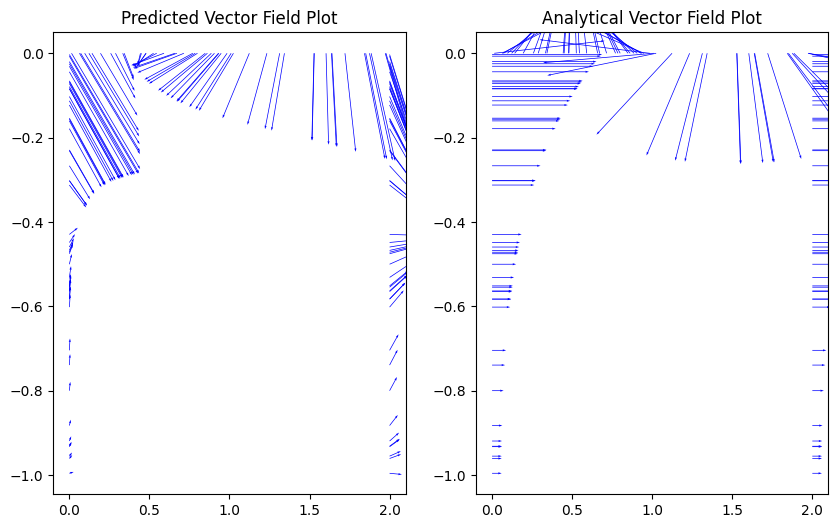

In [ ]:
def plotVelocity(total_test_data,total_test_data_scaled,prediction, ax):

  if prediction:
    u_values, v_values = compute_output_grad(total_test_data_scaled)
  else:
    u_values, v_values = velocity_func(total_test_data.detach().numpy())

  # Plotting
  x_values = total_test_data[:, 0].detach().numpy()
  y_values = total_test_data[:, 1].detach().numpy()
  if prediction:
    u_values = u_values.detach().numpy()
    v_values = v_values.detach().numpy()



  # Plotting the vector field
  ax.quiver(x_values, y_values, u_values, v_values, scale=.5, angles = 'xy',color='blue', width=0.002)
  if prediction:
    ax.set_title('Predicted Vector Field Plot')
  else:
    ax.set_title('Analytical Vector Field Plot')


  return torch.from_numpy(u_values).view(-1,1), torch.from_numpy(v_values).view(-1,1)

fig, axs = plt.subplots(1,2,figsize=(10,6 ))
u_predicted,v_predicted=plotVelocity(total_test_data,total_test_data_scaled,True,ax = axs[0])
u_analytical,v_analytical= plotVelocity(total_test_data,total_test_data_scaled,False,ax = axs[1])

#print(u_analytical)
#print(u_predicted)
#print(total_test_data)

In [ ]:
criterion=torch.nn.L1Loss()

u_loss=criterion(torch.Tensor(u_analytical),u_predicted)

v_loss=criterion(torch.Tensor(v_analytical), v_predicted)

print(f'Relative error u velocity: {abs(u_loss)/abs(torch.mean(torch.Tensor(u_analytical)))*100}%')
print(f'Relative error v velocity: {abs(v_loss)/abs(torch.mean(torch.Tensor(v_analytical)))*100}%')

Relative error u velocity: 401.448974609375%
Relative error v velocity: 24035.1171875%


#Model with body

##Normalize data with body data inserted

In [ ]:
def normalize_data_body_inserted(data_function_approximation,data_boundary_conditions_0,data_boundary_conditions_1,data_pde_loss,data_vel_bottom,data_body_b,data_body_t,data_body_r,data_body_l,data_size,data_body_size):
  total_input_train_data=[]

  total_input_train_data.extend(data_function_approximation)
  total_input_train_data.extend(data_boundary_conditions_0)
  total_input_train_data.extend(data_boundary_conditions_1)
  total_input_train_data.extend(data_pde_loss)
  total_input_train_data.extend(data_vel_bottom)
  total_input_train_data.extend(data_body_b)
  total_input_train_data.extend(data_body_t)
  total_input_train_data.extend(data_body_r)
  total_input_train_data.extend(data_body_l)


  scaler = StandardScaler()
  total_input_train_data_scaled= scaler.fit_transform(total_input_train_data)


  input_data_function_approximation = total_input_train_data_scaled[0:data_size,:]
  input_data_boundary_conditions_0 = total_input_train_data_scaled[data_size:2*data_size,:]
  input_data_boundary_conditions_1 = total_input_train_data_scaled[2*data_size:3*data_size,:]
  input_data_pde_loss = total_input_train_data_scaled[3*data_size:4*data_size,:]
  input_data_vel_bottom = total_input_train_data_scaled[4*data_size:5*data_size,:]

  data_index= 5*data_size
  #print(data_index,data_index+data_body_size)
  input_data_body_b = total_input_train_data_scaled[data_index:data_index+data_body_size,:]
  #print(data_index +data_body_size,data_index+2*data_body_size)
  input_data_body_t = total_input_train_data_scaled[data_index+data_body_size:data_index+2*data_body_size,:]
  #print(data_index+ 2*data_body_size,data_index+3*data_body_size)
  input_data_body_r = total_input_train_data_scaled[data_index+2*data_body_size:data_index+3*data_body_size,:]
  #print(data_index+ 3*data_body_size,data_index+4*data_body_size)
  input_data_body_l = total_input_train_data_scaled[data_index+3*data_body_size:data_index+4*data_body_size,:]

  #print(input_data_body_l.shape)
  #print(data_index+3*data_body_size,data_index+4*data_body_size)


  return input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, input_data_body_b, input_data_body_t, input_data_body_r, input_data_body_l

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Define parameters
num_epochs = 5000
learning_rate = 10**-4
momentum = 0.9
#alpha = 1.0  # Weight for data loss
#beta = 1.0   # Weight for periodic boundary condition loss
#epsilon = 1.0 # Weight for bottom velocity boundary condition loss
#gamma = 1.0  # Weight for PDE loss


# Create the model and optimizer
model = FNN()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

training_data_size=20
training_body_data_size=20
test_data_size=8
test_body_data_size=8

# Generate training data for each component of the PINN loss
input_data_function_approximation, target_data_function_approximation = generate_data_function_approximation(training_data_size)
input_data_boundary_conditions_0, input_data_boundary_conditions_1 = generate_periodic_boundary_data(training_data_size, x1_values=[0, 2])
input_data_pde_loss = generate_data_pde_loss_with_body(training_data_size)
input_data_vel_bottom = generate_data_bottom_velocity(training_data_size)

input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l= generate_data_body(training_body_data_size);


#normalize data
input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom, input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l = normalize_data_body_inserted(input_data_function_approximation, input_data_boundary_conditions_0,input_data_boundary_conditions_1, input_data_pde_loss, input_data_vel_bottom,input_data_body_b,input_data_body_t,input_data_body_r,input_data_body_l,training_data_size,training_body_data_size)

print(input_data_boundary_conditions_1)
# Change 1: Create a SoftAdapt object (with your desired variant)
softadapt_object = LossWeightedSoftAdapt(beta=0.1)

# Change 2: Define how often SoftAdapt calculate weights for the loss components
epochs_to_make_updates = 5

# Change 3: Initialize lists to keep track of loss values over the epochs we defined above
values_of_component_1 = []
values_of_component_2 = []
values_of_component_3 = []
values_of_component_4 = []
values_of_component_5 = []
# Initializing adaptive weights to all ones.
adapt_weights = torch.tensor([1,1,1,1,1])

[[ 1.72151057 -1.11865516]
 [ 1.72151057 -1.51154406]
 [ 1.72151057  0.20968685]
 [ 1.72151057 -0.72022602]
 [ 1.72151057  1.46313001]
 [ 1.72151057  0.8220807 ]
 [ 1.72151057  1.42048618]
 [ 1.72151057 -1.19711622]
 [ 1.72151057  0.11881979]
 [ 1.72151057 -0.03174047]
 [ 1.72151057  0.91360021]
 [ 1.72151057 -1.61778489]
 [ 1.72151057  0.93185653]
 [ 1.72151057  0.56437255]
 [ 1.72151057  0.85393038]
 [ 1.72151057  0.06723784]
 [ 1.72151057  1.13167806]
 [ 1.72151057 -0.00685979]
 [ 1.72151057 -0.49128073]
 [ 1.72151057  1.0179023 ]]


In [ ]:
# Lists to store training losses for plotting
loss_pde_list = []
#loss_bc_list = []
loss_data_list = []
total_loss_list = []
loss_per_bc_list=[]
loss_bot_vel_bc_list=[]
loss_body_list=[]

# Lists to store test losses for plotting
test_loss_pde_list = []
#test_loss_bc_list = []
test_loss_data_list = []
test_total_loss_list = []
test_loss_per_bc_list=[]
test_loss_bot_vel_bc_list=[]
test_loss_body_list=[]

# Training loop
for epoch in range(num_epochs):


    # Forward pass for each component
    predicted_data_function_approximation = model(torch.from_numpy(input_data_function_approximation).float())

    # Compute losses
    loss_function_approximation = data_loss(predicted_data_function_approximation, torch.Tensor(target_data_function_approximation).float())

    boundary_conditions = {
      'bc1': compute_bc1(model, input_data_vel_bottom[:,0], input_data_vel_bottom[:,1]),   # at x2=-1 the grad perpendicular to the bottom is null
      'bc2_0': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_0)),  # at x1 = 0
      'bc2_1': compute_bc2(model,torch.Tensor( input_data_boundary_conditions_1)),  # at x1 = 2
      'bc_body_t':compute_bc1(model, input_data_body_t[:,0], input_data_body_t[:, 1]),
      'bc_body_b':compute_bc1(model, input_data_body_b[:, 0], input_data_body_b[:, 1]),
      'bc_body_r':compute_bc3(model, input_data_body_r[:, 0], input_data_body_r[:, 1]),
      'bc_body_l':compute_bc3(model, input_data_body_l[:, 0], input_data_body_l[:, 1]),
    }

    #loss_boundary_conditions = beta* boundary_condition_loss(boundary_conditions,predicted_data_function_approximation)

    loss_periodic_boundary = periodic_boundary_loss(boundary_conditions)

    loss_pde_loss= pde_loss(model,torch.tensor(input_data_pde_loss, requires_grad = True, dtype=torch.float))

    loss_vel_bottom_boundary = bottom_velocity_boundary_loss(boundary_conditions,predicted_data_function_approximation)

    loss_body= body_boundary_loss(boundary_conditions,predicted_data_function_approximation); #WARNING: if data_size != data_body_size, we need a different array


    # Keeping track of each loss component
    values_of_component_1.append(loss_function_approximation)
    values_of_component_2.append( loss_periodic_boundary )
    values_of_component_3.append(loss_pde_loss)
    values_of_component_4.append(loss_vel_bottom_boundary)
    values_of_component_5.append(loss_body)


    # Change 4: Make sure `epochs_to_make_change` have passed before calling SoftAdapt.
    if epoch % epochs_to_make_updates == 0 and epoch != 0:
        adapt_weights = softadapt_object.get_component_weights(torch.tensor(values_of_component_1),
                                                                 torch.tensor(values_of_component_2),
                                                                 torch.tensor(values_of_component_3),
                                                                torch.tensor(values_of_component_4),
                                                               torch.tensor(values_of_component_5),
                                                                 verbose=False,
                                                                   )
        # Resetting the lists to start fresh (this part is optional)
        values_of_component_1 = []
        values_of_component_2 = []
        values_of_component_3 = []
        values_of_component_4 = []
        values_of_component_5 = []



    # Total loss
    #total_loss = loss_function_approximation + loss_boundary_conditions + loss_pde_loss

    #total_loss = loss_function_approximation + loss_periodic_boundary + loss_vel_bottom_boundary + loss_pde_loss

    total_loss = adapt_weights[0] * loss_function_approximation + 10*adapt_weights[1]*loss_periodic_boundary + 10*adapt_weights[2]*loss_pde_loss + adapt_weights[3]*loss_vel_bottom_boundary + adapt_weights[4]*loss_body
    # Backward pass and optimization
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()



    # Append losses to the lists
    loss_pde_list.append(loss_pde_loss.item())
    #loss_bc_list.append(loss_boundary_conditions.item())
    loss_per_bc_list.append(loss_periodic_boundary.item())
    loss_bot_vel_bc_list.append(loss_vel_bottom_boundary.item())
    loss_data_list.append(loss_function_approximation.item())
    loss_body_list.append(loss_body.item()) #body loss
    total_loss_list.append(total_loss.item())

    # Generate test data for each component of the PINN loss
    test_input_data_function_approximation, test_target_data_function_approximation = generate_data_function_approximation(test_data_size)
    test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1 = generate_periodic_boundary_data(test_data_size, x1_values=[0, 2])
    test_input_data_pde_loss = generate_data_pde_loss_with_body(test_data_size)
    test_input_data_vel_bottom = generate_data_bottom_velocity(test_data_size)
    test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l= generate_data_body(test_body_data_size);

    #print(test_input_data_body_l.shape)

    #normalize data
    test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l = normalize_data_body_inserted(test_input_data_function_approximation, test_input_data_boundary_conditions_0, test_input_data_boundary_conditions_1, test_input_data_pde_loss, test_input_data_vel_bottom, test_input_data_body_b,test_input_data_body_t,test_input_data_body_r,test_input_data_body_l,test_data_size,test_body_data_size)

    #print(test_input_data_body_l.shape)
    # Test loop
    # Forward pass for each component
    test_predicted_data_function_approximation = model(torch.Tensor(test_input_data_function_approximation))

    # Compute test losses
    test_loss_function_approximation = data_loss(test_predicted_data_function_approximation, torch.Tensor(test_target_data_function_approximation))

    test_boundary_conditions = {
        'bc1': compute_bc1(model, test_input_data_vel_bottom[:, 0], test_input_data_vel_bottom[:, 1]),
        'bc2_0': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_0)),
        'bc2_1': compute_bc2(model, torch.Tensor(test_input_data_boundary_conditions_1)),
        'bc_body_t':compute_bc1(model, test_input_data_body_t[:,0], test_input_data_body_t[:, 1]),
        'bc_body_b':compute_bc1(model, test_input_data_body_b[:, 0], test_input_data_body_b[:, 1]),
        'bc_body_r':compute_bc3(model, test_input_data_body_r[:, 0], test_input_data_body_r[:, 1]),
        'bc_body_l':compute_bc3(model, test_input_data_body_l[:, 0], test_input_data_body_l[:, 1]),
    }

    #test_loss_boundary_conditions = beta*boundary_condition_loss(test_boundary_conditions, test_predicted_data_function_approximation)

    test_loss_periodic_boundary = periodic_boundary_loss(test_boundary_conditions)

    test_loss_vel_bottom_boundary = bottom_velocity_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation)

    test_loss_pde_loss = pde_loss(model, torch.tensor(test_input_data_pde_loss, requires_grad = True, dtype=torch.float))

    test_loss_body= body_boundary_loss(test_boundary_conditions,test_predicted_data_function_approximation); #WARNING: if data_size != data_body_size, we need a different array

    # Total test loss
    #test_total_loss = test_loss_function_approximation + test_loss_boundary_conditions + test_loss_pde_loss
    test_total_loss = test_loss_function_approximation + test_loss_periodic_boundary + test_loss_vel_bottom_boundary + test_loss_pde_loss

    # Append test losses to the lists
    test_loss_pde_list.append(test_loss_pde_loss.item())
    #test_loss_bc_list.append(test_loss_boundary_conditions.item())
    test_loss_bot_vel_bc_list.append(test_loss_vel_bottom_boundary.item())
    test_loss_per_bc_list.append(test_loss_periodic_boundary.item())
    test_loss_data_list.append(test_loss_function_approximation.item())
    test_loss_body_list.append(test_loss_body.item()) #body loss
    test_total_loss_list.append(test_total_loss.item())

    # Print loss for monitoring
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs},train PDE Loss: {loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},train Boundaries Loss: {loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},train Periodic Boundary Loss: {loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Bottom Velocity Boundary Loss: {loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},train Data Loss: {loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},train Body Loss: {loss_body}')
        print(f'Epoch {epoch}/{num_epochs},train Total Loss: {total_loss.item()}')
        print("------------------------------------------------------------")
        print(f'Epoch {epoch}/{num_epochs},test PDE Loss: {test_loss_pde_loss}')
        #print(f'Epoch {epoch}/{num_epochs},test Boundaries Loss: {test_loss_boundary_conditions}')
        print(f'Epoch {epoch}/{num_epochs},test Periodic Boundary Loss: {test_loss_periodic_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Bottom Velocity Boundary Loss: {test_loss_vel_bottom_boundary}')
        print(f'Epoch {epoch}/{num_epochs},test Data Loss: {test_loss_function_approximation}')
        print(f'Epoch {epoch}/{num_epochs},test Body Loss: {test_loss_body}')
        print(f'Epoch {epoch}/{num_epochs},test Total Loss: {test_total_loss.item()}')
        print("#############################################################")
        print("#############################################################")
# After training, you can use the trained model for predictions or further analysis


Epoch 0/5000,train PDE Loss: 0.004185958299785852
Epoch 0/5000,train Periodic Boundary Loss: 0.06273075938224792
Epoch 0/5000,train Bottom Velocity Boundary Loss: 0.005751279182732105
Epoch 0/5000,train Data Loss: 0.06531882286071777
Epoch 0/5000,train Body Loss: 0.056946441531181335
Epoch 0/5000,train Total Loss: 0.7971836924552917
------------------------------------------------------------
Epoch 0/5000,test PDE Loss: 0.0024953829124569893
Epoch 0/5000,test Periodic Boundary Loss: 0.03689691424369812
Epoch 0/5000,test Bottom Velocity Boundary Loss: 0.004657684825360775
Epoch 0/5000,test Data Loss: 0.02067403681576252
Epoch 0/5000,test Body Loss: 0.0351487398147583
Epoch 0/5000,test Total Loss: 0.06472402065992355
#############################################################
#############################################################
Epoch 100/5000,train PDE Loss: 0.000649525027256459
Epoch 100/5000,train Periodic Boundary Loss: 0.0016571215819567442
Epoch 100/5000,train Bottom Velo